# CIP — Cifra de Integridade Primal
## Protocolo Público de Integridade Digital
### Demonstração Institucional (Notebook Reprodutível)

Este notebook documenta, de forma pública e verificável, o funcionamento integral do protocolo de  
integridade digital baseado na estrutura aritmética da CIP.

O objetivo é demonstrar — de ponta a ponta e sem qualquer dependência de segredos — o ciclo completo:

1. **assinar** (integridade);
2. **verificar** (validação de integridade);
3. **cifrar** (confidencialidade);
4. **decifrar** (reversão íntegra).

A demonstração utiliza o binário oficial da CIP em modo demonstração (100 operações de verificação ou  
decifragem), incluindo o contador interno protegido pelo próprio protocolo.

> **Este documento não expõe nenhum segredo criptográfico.**  
> Toda a segurança decorre exclusivamente da estrutura espectral pública utilizada pelo protocolo.

---

## Sumário Executivo

1. **A GOE aritmética é um fenômeno real, reprodutível e independente do observador.**  
   Ela emerge diretamente da aritmética, não de heurísticas ou métodos numéricos.

2. **A CIP operacionaliza esse fenômeno na forma de um protocolo de integridade digital.**  
   Alterações mínimas — inclusive 1 bit — são detectadas de forma determinística.

3. **O protocolo é reprodutível em qualquer ambiente técnico.**  
   Linux e Windows produzem resultados idênticos usando apenas o binário nativo em `C++`.

4. **O ciclo assinar–verificar–cifrar–decifrar é totalmente coerente.**  
   A mesma estrutura que detecta alteração garante reversão perfeita.

5. **O impacto institucional é amplo.**  
   Governo, indústria, BigTechs, sistema financeiro, justiça e defesa têm aplicações imediatas.

A fundamentação teórica está pública e pode ser avaliada em Costa, A. (2025). The Arithmetic Mirror: Deterministic Emergence  
of GOE Statistics from the Prime Structure. Zenodo. https://doi.org/10.5281/zenodo.17643156

---

## Modos de Operação da CIP

A CIP opera em dois modos de assinatura e verificação. Ambos seguem o mesmo protocolo, mas com  
profundidades distintas — adequadas a contextos diferentes.

A distinção precisa entre esses modos é essencial para auditoria, documentação técnica e uso institucional.

### 1. Modo Padrão (default)

O modo padrão realiza uma verificação leve e otimizada:

- Avalia **15 blocos** do arquivo (5 iniciais, 5 centrais, 5 finais);
- Produz chaves e auditorias menores;
- Ideal para uso operacional de alto volume;
- Detecta qualquer alteração significativa.

**Resumo:** desempenho elevado com cobertura consistente para operações rotineiras.

### 2. Modo Total (-t)

O modo total realiza a verificação estrutural completa:

- Avalia **todos os blocos** do arquivo;
- Embute a matriz de projeção diretamente na chave CIPT;
- Gera assinatura vetorial integral e perpétua;
- Mantém interoperabilidade plena entre SDKs;
- Recomendado para:
  - setor público,
  - cadeia de custódia,
  - documentos oficiais,
  - preservação digital,
  - processos de alto valor.

**Resumo:** verificação determinística, completa e independente de versões.

### Comparativo Objetivo

| Propriedade | Modo Padrão | Modo Total |
|------------|-------------|------------|
| Blocos verificados | 15 (5+5+5) | 100% |
| Matriz embutida | Sim | Sim |
| Tamanho da chave | Menor | Maior |
| Finalidade | Operacional | Institucional |
| Custódia e transparência | Adequado | Recomendado |
| Sensibilidade a alterações mínimas | Parcial | Completa |

<br>

> Em termos operacionais, o modo padrão é adequado à integridade corrente de arquivos comuns;  
> o modo total (-t) foi projetado para decisões críticas, em que qualquer margem de dúvida é inaceitável.


## 1. Pré-requisitos

Para executar este notebook de demonstração, é necessário:

- possuir o binário `cip` (Linux) ou `cip.exe` (Windows) disponível localmente;
- ter o pacote de demonstração (SDK CIP Demo) corretamente descompactado;
- utilizar Python 3 com Jupyter Notebook ou JupyterLab.

> **A CIP não utiliza infraestrutura de PKI.**  
> Não depende de certificados digitais, RSA/ECDSA, chaves privadas ou autoridade certificadora.  
> A integridade é garantida exclusivamente pela estrutura aritmética do protocolo.

**Todas as operações deste notebook invocam o binário da CIP, compilado em `C++` (OpenMP + Eigen) e disponibilizado para Linux e Windows.  
Não há execução interpretada: o notebook apenas orquestra chamadas ao executável nativo.**

A seguir, configuramos os caminhos básicos e os utilitários necessários para a execução.


In [1]:
# =================================================================
# CÉLULA 1 — Download e preparação limpa do SDK CIP (Windows/Linux)
# =================================================================

import os
import stat
import json
import requests
import shutil
import zipfile
import time
import subprocess
import random
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm import tqdm

# ------------------------------------------------------------
# 1. Diretório base do notebook
# ------------------------------------------------------------
BASE_DIR = Path.cwd()
print(f"[INFO] Diretório base do notebook: {BASE_DIR}")

# ------------------------------------------------------------
# 2. Identificação automática do sistema operacional
# ------------------------------------------------------------
WINDOWS = os.name == "nt"

if WINDOWS:
    ZIP_NAME = "cip-sdk-windows-idx0.zip"
    SDK_FOLDER = "cip-sdk-windows-idx0"
    DOWNLOAD_URL = "https://delta-cip.com.br/downloads/cip-sdk-windows-idx0.zip"
else:
    ZIP_NAME = "cip-sdk-linux-idx0.zip"
    SDK_FOLDER = "cip-sdk-linux-idx0"
    DOWNLOAD_URL = "https://delta-cip.com.br/downloads/cip-sdk-linux-idx0.zip"

SDK_DIR = BASE_DIR / SDK_FOLDER
ZIP_PATH = BASE_DIR / ZIP_NAME

print(f"[INFO] Sistema detectado: {'Windows' if WINDOWS else 'Linux'}")
print(f"[INFO] Arquivo ZIP esperado: {ZIP_NAME}")
print(f"[INFO] Pasta para extração: {SDK_DIR}")

# ------------------------------------------------------------
# 3. Uso do SDK local, se já estiver presente
# ------------------------------------------------------------
if SDK_DIR.exists():
    print(f"[OK] SDK encontrado localmente em: {SDK_DIR}")

else:
    # --------------------------------------------------------
    # 4. Download do ZIP somente se necessário
    # --------------------------------------------------------
    if not ZIP_PATH.exists():
        print("[INFO] Baixando SDK a partir do site oficial da CIP...")

        with requests.get(DOWNLOAD_URL, stream=True) as r:
            r.raise_for_status()
            with open(ZIP_PATH, "wb") as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)

        print(f"[OK] Download concluído: {ZIP_PATH}")

    else:
        print(f"[OK] Arquivo ZIP já disponível localmente: {ZIP_PATH}")

    # --------------------------------------------------------
    # 5. Extração do SDK
    # --------------------------------------------------------
    print(f"[INFO] Extraindo o SDK para: {SDK_DIR}")
    SDK_DIR.mkdir(exist_ok=True)

    with zipfile.ZipFile(ZIP_PATH, "r") as z:
        z.extractall(SDK_DIR)

    print("[OK] Extração concluída com sucesso.")

# ------------------------------------------------------------
# 6. Identificação do executável correto
# ------------------------------------------------------------
BIN_LINUX = SDK_DIR / "bin" / "cip"
BIN_WINDOWS = SDK_DIR / "bin" / "cip.exe"

if WINDOWS:
    if not BIN_WINDOWS.exists():
        raise FileNotFoundError(f"[ERRO] cip.exe não encontrado em: {BIN_WINDOWS}")
    CIP_BIN = BIN_WINDOWS
else:
    if not BIN_LINUX.exists():
        raise FileNotFoundError(f"[ERRO] cip (Linux) não encontrado em: {BIN_LINUX}")
    # Permitir execução no Linux
    st = os.stat(BIN_LINUX)
    os.chmod(BIN_LINUX, st.st_mode | stat.S_IXUSR | stat.S_IXGRP | stat.S_IXOTH)
    CIP_BIN = BIN_LINUX

print(f"[OK] Binário CIP identificado em: {CIP_BIN}")

# ------------------------------------------------------------
# 7. Diretório para testes de estresse
# ------------------------------------------------------------
STRESS_DIR = BASE_DIR / "stress_test"
STRESS_DIR.mkdir(exist_ok=True)
print(f"[OK] Diretório de stress test criado em: {STRESS_DIR}")

# ------------------------------------------------------------
# 8. Limite de segurança (1GB)
# ------------------------------------------------------------
LIMITE_BYTES = 1_000_000_000  # 1GB
print(f"[OK] Limite operacional definido: {LIMITE_BYTES/1e6:.1f} MB")


[INFO] Diretório base do notebook: /home/alvaro/cip_viana
[INFO] Sistema detectado: Linux
[INFO] Arquivo ZIP esperado: cip-sdk-linux-idx0.zip
[INFO] Pasta para extração: /home/alvaro/cip_viana/cip-sdk-linux-idx0
[OK] SDK encontrado localmente em: /home/alvaro/cip_viana/cip-sdk-linux-idx0
[OK] Binário CIP identificado em: /home/alvaro/cip_viana/cip-sdk-linux-idx0/bin/cip
[OK] Diretório de stress test criado em: /home/alvaro/cip_viana/stress_test
[OK] Limite operacional definido: 1000.0 MB


In [2]:
# ==============================================================
# CÉLULA 2 — Download de arquivo grande e estável (NOAA ~100 MB)
# ==============================================================

# Arquivo NOAA público, estável e suficientemente grande para testes de integridade
URL_GRANDE = "https://www.ncei.noaa.gov/data/global-summary-of-the-day/archive/2023.tar.gz"
arquivo_grande = STRESS_DIR / "noaa_gsod_2023.tar.gz"

print(f"[INFO] Arquivo alvo local: {arquivo_grande}")

# ------------------------------------------------------------
# 1. Verificação de existência prévia
# ------------------------------------------------------------
if arquivo_grande.exists():
    tamanho = arquivo_grande.stat().st_size
    print(f"[OK] Arquivo encontrado localmente ({tamanho/1e6:.1f} MB).")

else:
    # --------------------------------------------------------
    # 2. Download com barra de progresso
    # --------------------------------------------------------
    print(f"\n[INFO] Iniciando download de arquivo grande para teste de integridade:")
    print(f"[INFO] Fonte oficial NOAA: {URL_GRANDE}")
    print(f"[INFO] Destino: {arquivo_grande}\n")

    with requests.get(URL_GRANDE, stream=True) as r:
        r.raise_for_status()

        tamanho_total = int(r.headers.get("Content-Length", 0))
        bloco = 1_048_576  # 1 MB

        # Barra de progresso
        with open(arquivo_grande, "wb") as f, tqdm(
            total=tamanho_total if tamanho_total > 0 else None,
            unit="B",
            unit_scale=True,
            unit_divisor=1024,
            desc="Baixando NOAA GSOD 2023",
            miniters=1
        ) as barra:

            for chunk in r.iter_content(chunk_size=bloco):
                if chunk:
                    f.write(chunk)
                    barra.update(len(chunk))

    tamanho = arquivo_grande.stat().st_size
    print(f"\n[OK] Download concluído ({tamanho/1e6:.1f} MB).")

# ------------------------------------------------------------
# 3. Validações de segurança
# ------------------------------------------------------------
if tamanho == 0:
    raise RuntimeError("[ERRO] Falha no download — arquivo com tamanho zero.")

if tamanho > LIMITE_BYTES:
    raise RuntimeError("[ERRO] Arquivo excede o limite de 1 GB definido para esta demonstração.")

print(f"[OK] Arquivo dentro do limite permitido ({LIMITE_BYTES/1e6:.1f} MB).")

# ------------------------------------------------------------
# 4. Justificativa institucional
# ------------------------------------------------------------
print("\n[INFO] O arquivo NOAA (Global Summary of the Day) é público, estável e suficientemente grande para representar cenários reais de")
print("auditoria digital — como backups, logs consolidados, imagens e artefatos de sistemas. Ele será utilizado para demonstrar a integridade")
print("espectral da CIP sobre dados volumétricos.")


[INFO] Arquivo alvo local: /home/alvaro/cip_viana/stress_test/noaa_gsod_2023.tar.gz
[OK] Arquivo encontrado localmente (108.8 MB).
[OK] Arquivo dentro do limite permitido (1000.0 MB).

[INFO] O arquivo NOAA (Global Summary of the Day) é público, estável e suficientemente grande para representar cenários reais de
auditoria digital — como backups, logs consolidados, imagens e artefatos de sistemas. Ele será utilizado para demonstrar a integridade
espectral da CIP sobre dados volumétricos.


In [3]:
# ============================================================
# CÉLULA 3 — Inspeção inicial e criação da cópia de trabalho
# ============================================================

# Arquivo obtido na CÉLULA 2
arquivo_original_grande = arquivo_grande

# ------------------------------------------------------------
# 1. Verificação da existência do arquivo
# ------------------------------------------------------------
if not arquivo_original_grande.exists():
    raise FileNotFoundError("[ERRO] Arquivo original não encontrado. Verifique a CÉLULA 2.")

print(f"[OK] Arquivo carregado para inspeção: {arquivo_original_grande}")

# ------------------------------------------------------------
# 2. Informações básicas do arquivo
# ------------------------------------------------------------
tamanho_bytes = arquivo_original_grande.stat().st_size
tamanho_mb = tamanho_bytes / 1e6

print(f"[INFO] Nome................: {arquivo_original_grande.name}")
print(f"[INFO] Tamanho (bytes).....: {tamanho_bytes:,}")
print(f"[INFO] Tamanho (MB)........: {tamanho_mb:.2f}")

# ------------------------------------------------------------
# 3. Validações de segurança
# ------------------------------------------------------------
if tamanho_bytes == 0:
    raise RuntimeError("[ERRO] Arquivo baixado com tamanho zero.")

if tamanho_bytes > LIMITE_BYTES:
    raise RuntimeError(
        f"[ERRO] Arquivo excede o limite permitido de 1 GB "
        f"({tamanho_bytes/1e6:.1f} MB)."
    )

# ------------------------------------------------------------
# 4. Criação da cópia de trabalho (cadeia de custódia)
# ------------------------------------------------------------
arquivo_trabalho = STRESS_DIR / f"{arquivo_original_grande.stem}_work{arquivo_original_grande.suffix}"
shutil.copy2(arquivo_original_grande, arquivo_trabalho)

print(f"[OK] Cópia de trabalho criada em: {arquivo_trabalho}")
print("[INFO] Todas as alterações e corrupções serão realizadas exclusivamente na cópia, "
      "preservando o artefato original para fins de auditoria e reprodutibilidade.")


[OK] Arquivo carregado para inspeção: /home/alvaro/cip_viana/stress_test/noaa_gsod_2023.tar.gz
[INFO] Nome................: noaa_gsod_2023.tar.gz
[INFO] Tamanho (bytes).....: 108,776,234
[INFO] Tamanho (MB)........: 108.78
[OK] Cópia de trabalho criada em: /home/alvaro/cip_viana/stress_test/noaa_gsod_2023.tar_work.gz
[INFO] Todas as alterações e corrupções serão realizadas exclusivamente na cópia, preservando o artefato original para fins de auditoria e reprodutibilidade.


In [4]:
# ============================================================
# CÉLULA 4 — Assinatura do arquivo original em modo TOTAL (-t)
# ============================================================

def run_cip(args):
    """
    Executa o binário CIP com os argumentos especificados,
    medindo o tempo de execução e capturando stdout/stderr.
    
    Configurada para assegurar robustez no Windows (UTF-8)
    e comportamento idêntico em Linux.
    """
    inicio = time.time()
    proc = subprocess.run(
        [str(CIP_BIN)] + args,
        cwd=SDK_DIR,
        capture_output=True,
        text=True,
        encoding="utf-8",
        errors="replace"
    )
    duracao = time.time() - inicio
    return proc, duracao


print("\n===================================================")
print("   ASSINATURA DO ARQUIVO ORIGINAL (MODO TOTAL -t)")
print("===================================================\n")

# ------------------------------------------------------------
# 1. Execução da assinatura em modo total (-t)
# ------------------------------------------------------------
args_assinar = ["-t", "assinar", str(arquivo_original_grande)]
proc_assinar, tempo_assinatura = run_cip(args_assinar)

print("[STDOUT]\n")
print(proc_assinar.stdout)

if proc_assinar.returncode != 0:
    print("\n[STDERR]\n")
    print(proc_assinar.stderr)
    raise RuntimeError("[ERRO] Falha na assinatura do arquivo original.")

print(f"[OK] Assinatura concluída em {tempo_assinatura:.3f} s")

# ------------------------------------------------------------
# 2. Localização da chave gerada
# ------------------------------------------------------------
pasta_cip = arquivo_original_grande.parent / ".cip" / "chaves_cipt"
chaves = sorted(pasta_cip.glob("*assinado*.json"))

if not chaves:
    raise RuntimeError("[ERRO] Não foi possível localizar a chave de assinatura.")

chave_assinatura = chaves[-1]

print(f"[OK] Chave de assinatura detectada em:\n{chave_assinatura}")

# ------------------------------------------------------------
# 3. Explicação institucional
# ------------------------------------------------------------
print("\n[INFO] O arquivo foi assinado em modo TOTAL (-t).")
print("[INFO] Esse modo produz a assinatura vetorial completa, baseada em todos os blocos do arquivo,")
print("       incorporando a matriz de projeção diretamente na chave CIPT. O resultado é uma assinatura")
print("       perpétua, reprodutível e independente de versões — recomendada para cadeia de custódia,")
print("       processos oficiais e preservação digital de longo prazo.")

# Exibir conteúdo da chave CIPT gerada em modo total

with open(chave_assinatura, "r", encoding="utf-8") as f:
    dados_chave = json.load(f)

print("\n=== Estrutura da Chave CIPT (resumo) ===\n")
print(json.dumps(dados_chave, indent=2)[:4000])  # primeiras 4000 chars

print("\n[INFO] A chave acima representa:")
print(" - a assinatura vetorial completa do arquivo;")
print(" - os parâmetros auditáveis do processo;")
print(" - a matriz de projeção embutida;")
print(" - o identificador espectral único;")
print(" - nenhum segredo criptográfico (estrutura pública).")



   ASSINATURA DO ARQUIVO ORIGINAL (MODO TOTAL -t)

[STDOUT]

[INFO] OpenMP: 18 threads.
[INFO] Eigen: 18 threads.

════════════════[ CIP - Configuração SDK ]════════════════
[INFO] Idx do SDK determinado automaticamente: 0
[SUCESSO] Configuração do SDK (idx 0) carregada com sucesso.
[INFO] Idx da matriz de Assinatura (pré-calculada): 0 | Idx da matriz de Cifragem (pré-calculada): 1

═════════════[ CIP - Assinatura (MODO TOTAL) ]══════════════
[INFO] Arquivo original: noaa_gsod_2023.tar.gz
[INFO] Tamanho do arquivo: 103.7 MB (108776234 bytes)
[INFO] Usando matriz de projeção P (16 x 1024).
[INFO] Indice da base harmonica utilizado (idx 0).
[INFO] Iniciando o core da assinatura TOTAL para o arquivo...
[INFO] Embutindo matriz de projeção na chave para interoperabilidade...
[INFO] Assinando a propria chave CIPT com a matriz de confiança universal...
[SUCESSO] Hash da chave CIPT gerado com sucesso.

════════════[ CIP: Assinatura TOTAL Finalizada ]════════════
[SUCESSO] Chave CIPT salva em:

In [5]:
# ==========================================================================
# CÉLULA 5 — Exibição e explicação da chave CIPT + auditoria CIPT (modo total)
# ==========================================================================

import json

print("\n====================================================")
print("   INSPEÇÃO DA CHAVE CIPT E DA AUDITORIA (TOTAL -t)")
print("====================================================\n")

# ------------------------------------------------------------
# 1. Carregar conteúdo da chave gerada
# ------------------------------------------------------------
with open(chave_assinatura, "r", encoding="utf-8") as f:
    dados_chave = json.load(f)

print(f"[OK] Chave CIPT carregada: {chave_assinatura}")

# ------------------------------------------------------------
# 2. Exibir resumo da chave (conteúdo truncado)
# ------------------------------------------------------------
texto_chave = json.dumps(dados_chave, indent=2)
print("\n=== Primeiras linhas da chave CIPT (resumo) ===\n")
print(texto_chave[:4000])
print("\n[INFO] (conteúdo truncado para legibilidade)\n")

# ------------------------------------------------------------
# 3. Localizar auditoria CIPT completa (modo total)
# ------------------------------------------------------------
pasta_auditoria = arquivo_original_grande.parent / ".cip" / "auditorias_cipt"
auditorias = sorted(pasta_auditoria.glob("auditoria_cipt_assinado_idx0_*.json"))

if not auditorias:
    raise RuntimeError("[ERRO] Auditoria CIPT não encontrada em auditorias_cipt/.")

auditoria_path = auditorias[-1]

print(f"[OK] Auditoria CIPT localizada:\n{auditoria_path}\n")

# ------------------------------------------------------------
# 4. Carregar e exibir trecho da auditoria
# ------------------------------------------------------------
with open(auditoria_path, "r", encoding="utf-8") as f:
    dados_auditoria = json.load(f)

texto_auditoria = json.dumps(dados_auditoria, indent=2)

print("=== Trecho da auditoria CIPT ===\n")
print(texto_auditoria[:2500])   # ~2500 chars iniciais
print("\n[INFO] (conteúdo truncado para legibilidade)\n")

# ------------------------------------------------------------
# 5. Explicação institucional da auditoria CIPT
# ------------------------------------------------------------
print("=== Relevância institucional da auditoria CIPT ===\n")
print(
    "- A auditoria CIPT, armazenada separadamente da chave, documenta integralmente o processo de "
    "assinatura total (-t), incluindo:\n"
    "    • blocos analisados (100% do arquivo),\n"
    "    • hashes intermediários e finais,\n"
    "    • parâmetros espectrais e índices,\n"
    "    • identificação da matriz de projeção (N),\n"
    "    • assinatura vetorial completa,\n"
    "    • data, hora e condições exatas da operação.\n\n"
    "- A existência da auditoria como artefato separado reforça:\n"
    "    1. CADEIA DE CUSTÓDIA — documentação formal do processo;\n"
    "    2. TRANSPARÊNCIA — não há segredos criptográficos nem parâmetros ocultos;\n"
    "    3. REPRODUTIBILIDADE — qualquer terceiro pode verificar os resultados de forma independente;\n"
    "    4. VALIDADE INSTITUCIONAL — adequado para ambientes de governo, justiça e auditoria;\n"
    "    5. COERÊNCIA ESTRUTURAL — o protocolo opera de modo inteiramente determinístico e público.\n"
)



   INSPEÇÃO DA CHAVE CIPT E DA AUDITORIA (TOTAL -t)

[OK] Chave CIPT carregada: /home/alvaro/cip_viana/stress_test/.cip/chaves_cipt/chave_cipt_assinado_idx18_N1024_20251124_115945.json

=== Primeiras linhas da chave CIPT (resumo) ===

{
  "arquivo_original_nome": "noaa_gsod_2023.tar.gz",
  "assinatura_integridade_chave_cipt": "46a81b7ee6fafd983d764ab43e7d46f07f8a2806019adbd9a2a347e1566bd85b",
  "assinatura_integridade_final": "77f210ad293d2957a514f2a1e44fe2be49b7db73c4f6e3dcb140c1dd9cd9b42c",
  "chave_ok": true,
  "comentario": "",
  "matrix_size_N_usado": 1024,
  "matriz_p_base64": "09W/vK1XRr07tos9cG0NPUk/TTzBAs89lDvZPKIPFLy171K9WJI1vaLPAjxRvhI8OX+YPcMTwL1tiwm8G1tsOzzivrw1Ska94XCLPbVfCz3xaUg8vAPLPec8H7s0J+K7yTZ8vJWr6LwkD0A9JfArvdqGiTzKmJO9uFQlPIGCBLyu7r28YzxGvUcriz1/Uwk9QSNDPKOyxz2gaqY8ahofPXGpGb2Fo9i8Db/ZPFjCIr3mi7U8mksFvsTAZzz1+5s8Kfu8vDcuRr1u5Yo90kgHPQxvPTzL3cA9G6UkPFLRqLv7ULi8Mt38vHeGgD1H4Bq96BqAO75d2b1GQ8K8xtFpvK8HvLywH0a9V5+KPaw/BT3k5jc82668PXBPQL2tgAM8PnwdvQN4z7zMDZc8N6KwOyoW

## Leitura e Interpretação da Chave CIPT e da Auditoria CIPT (modo total)

A assinatura total da CIP (`-t`) produz dois artefatos essenciais:

1. **A chave CIPT**, armazenada em `.cip/chaves_cipt/`, que contém:
   - a assinatura vetorial completa do arquivo;
   - os identificadores espectrais;
   - os parâmetros da matriz utilizada (`N`);
   - os hashes agregados;
   - metadados da operação;
   - os elementos necessários para reprodução da verificação.

2. **A auditoria CIPT**, armazenada em `.cip/auditorias_cipt/`, que registra:
   - os hashes de cada bloco de conteúdo;
   - o mapeamento completo dos blocos avaliados;
   - os parâmetros espectrais individuais;
   - dados estruturais da operação;
   - data, hora e metadados complementares.

A chave e a auditoria cumprem funções distintas e complementares:    
a chave concentra os elementos estruturantes da integridade, enquanto a auditoria documenta todo o processo de forma completa e independente.

Essa separação preserva a cadeia de custódia, aumenta a transparência e assegura que terceiros possam verificar o arquivo original de modo autônomo,  
sem depender do ambiente ou da implementação do autor.

### Padrão do Nome dos Arquivos CIPT

O arquivo de auditoria segue um padrão nominal determinístico, por exemplo:

`auditoria_cipt_assinado_idx0_N1024_20251123_170048.json`


Esse nome contém informações fundamentais para auditoria, rastreabilidade e cadeia de custódia:

- **auditoria_cipt** — indica que se trata de uma auditoria do modo total (CIPT).
- **assinado** — refere-se à operação de assinatura; outras operações geram sufixos específicos.
- **idx0** — identifica o índice do SDK utilizado (cada SDK possui idx próprio para interoperabilidade).
- **N1024** — dimensão da matriz espectral utilizada (potência de 2 definida por design).
- **20251123_170048** — timestamp completo da operação (`AAAAMMDD_HHMMSS`).

Esse padrão nominal permite:

1. **identificação inequívoca da operação**,  
2. **rastreamento confiável no tempo**,  
3. **compatibilidade entre implementações**,  
4. **verificação independente**,  
5. **forte valor probatório em auditoria técnica e jurídica**.

Os nomes são determinísticos e padronizados, preservando sempre o mesmo vocabulário operacional. Essa consistência é essencial para permitir  
interoperabilidade total entre SDKs distintos, ambientes institucionais e processos de verificação de longo prazo.


In [6]:
# =====================================================================================
# CÉLULA 6 — Verificação de integridade da cópia do arquivo original (MODO TOTAL -t)
# =====================================================================================

print("\n===============================================================")
print("   VERIFICAÇÃO DE INTEGRIDADE (MODO TOTAL -t) — ARQUIVO CÓPIA")
print("===============================================================\n")

shutil.copy2(arquivo_original_grande, arquivo_trabalho)

# ------------------------------------------------------------
# 1. Execução da verificação em modo total (-t)
# ------------------------------------------------------------
args_verificar = ["-t", "verificar", str(arquivo_trabalho), str(chave_assinatura)]
proc_verificar, tempo_verificacao = run_cip(args_verificar)

print("[STDOUT]\n")
print(proc_verificar.stdout)

if proc_verificar.returncode != 0:
    print("\n[STDERR]\n")
    print(proc_verificar.stderr)
    raise RuntimeError("[ERRO] Falha na verificação do arquivo de trabalho.")

print(f"[OK] Verificação de integridade concluída em {tempo_verificacao:.3f} s")

# ------------------------------------------------------------
# 2. Localização da chave de verificação gerada
# ------------------------------------------------------------
pasta_cip = arquivo_trabalho.parent / ".cip" / "chaves_cipt"
chaves = sorted(pasta_cip.glob("*verificado*.json"))

if not chaves:
    raise RuntimeError("[ERRO] Não foi possível localizar a chave gerada pela verificação.")

chave_verificacao = chaves[-1]

print("\n[OK] Chave de verificação detectada:")
print(chave_verificacao)

# ------------------------------------------------------------
# 3. Explicação institucional
# ------------------------------------------------------------
print("\n[INFO] Nesta etapa, o arquivo foi verificado em modo TOTAL (-t), o que significa:")
print("       • 100% dos blocos foram reprocessados;")
print("       • os vetores de integridade foram recalculados integralmente;")
print("       • a coerência espectral foi comparada com a assinatura original;")
print("       • uma nova chave 'verificado' foi registrada para fins de auditoria.\n")

print("[INFO] A verificação total é a operação recomendada para:")
print("       - cadeia de custódia,")
print("       - ambientes judiciais,")
print("       - auditoria formal,")
print("       - certificação de artefatos digitais de longo prazo.\n")



   VERIFICAÇÃO DE INTEGRIDADE (MODO TOTAL -t) — ARQUIVO CÓPIA

[STDOUT]

[INFO] OpenMP: 18 threads.
[INFO] Eigen: 18 threads.

════════════════[ CIP - Configuração SDK ]════════════════
[INFO] Idx do SDK determinado automaticamente: 0
[SUCESSO] Configuração do SDK (idx 0) carregada com sucesso.
[INFO] Idx da matriz de Assinatura (pré-calculada): 0 | Idx da matriz de Cifragem (pré-calculada): 1

════════════[ CIP - Verificação (MODO TOTAL) ]════════════
[INFO] Arquivo a ser verificado: noaa_gsod_2023.tar_work.gz
[INFO] Chave CIPT usada: chave_cipt_assinado_idx18_N1024_20251124_115945.json
[INFO] Verificando integridade da própria chave CIP-T...
[INFO] Hash esperado (assinatura_integridade_chave_cipt): 46a81b7ee6fafd983d764ab43e7d46f07f8a2806019adbd9a2a347e1566bd85b
[INFO] Hash calculado: 46a81b7ee6fafd983d764ab43e7d46f07f8a2806019adbd9a2a347e1566bd85b
[SUCESSO] Integridade da propria chave assinatura_integridade_chave_cipt: OK.
[AVISO] Nome do arquivo diferente, mas isso não compromete

In [7]:
# =========================================================================
# CÉLULA 7 — TESTE DE STRESS (10 corrupções de 1 bit + verificações totais)
# =========================================================================

"""
Nesta etapa, avaliamos a propriedade estrutural mais importante da CIP:
a sensibilidade espectral absoluta.

Cada corrupção altera *exatamente 1 bit* do arquivo de trabalho.
Após cada modificação, a CIP executa uma verificação total (-t),
reprocessando o arquivo integralmente e comparando sua estrutura
espectral com a assinatura original.

Qualquer alteração — mesmo 1 bit — deve resultar em ruptura total
da coerência espectral, gerando returncode != 0.
"""

resultados = []
tamanho_bytes_trabalho = arquivo_trabalho.stat().st_size

def corromper_um_bit(path: Path):
    """
    Altera exatamente 1 bit aleatório no arquivo.
    Retorna (pos_byte, bit, byte_original, byte_modificado).
    """
    with open(path, "r+b") as f:
        f.seek(0, os.SEEK_END)
        tamanho = f.tell()

        pos = random.randint(0, tamanho - 1)
        bit = random.randint(0, 7)

        f.seek(pos)
        byte_original = f.read(1)[0]

        mascara = 1 << bit
        byte_modificado = byte_original ^ mascara

        f.seek(pos)
        f.write(bytes([byte_modificado]))

    return pos, bit, byte_original, byte_modificado


print("\n===========================================================")
print("   TESTE DE STRESS — 10 corrupções independentes de 1 bit")
print("===========================================================\n")

for i in range(1, 11):
    print(f"\n--- ITERAÇÃO {i}/10 ---")

    # --------------------------------------------------------
    # 1. Corrupção de 1 bit
    # --------------------------------------------------------
    pos, bit, antigo, novo = corromper_um_bit(arquivo_trabalho)
    print(f"[OK] Bit modificado: byte {pos}, bit {bit} "
          f"({antigo:02x} → {novo:02x})")

    # --------------------------------------------------------
    # 2. Verificação total
    # --------------------------------------------------------
    proc_verif, tempo_verif = run_cip(
        ["-t", "verificar", str(arquivo_trabalho), str(chave_assinatura)]
    )

    print("\n[STDOUT]\n", proc_verif.stdout)

    if proc_verif.returncode == 0:
        raise RuntimeError(
            "ERRO CRÍTICO: A CIP não detectou a corrupção de 1 bit!"
        )

    resultados.append({
        "iteracao": i,
        "posicao_byte": pos,
        "bit": bit,
        "byte_original": f"{antigo:02x}",
        "byte_modificado": f"{novo:02x}",
        "tempo": tempo_verif,
        "codigo_retorno": proc_verif.returncode,
    })

    print(f"[OK] Corrupção detectada — tempo {tempo_verif:.3f} s")

print("\n===========================================================")
print("   FIM DO TESTE DE STRESS")
print("===========================================================\n")

print("Todas as 10 corrupções de 1 bit foram detectadas pela CIP.\n")
print("Este experimento demonstra a sensibilidade espectral absoluta:")
print("qualquer modificação mínima — 1 bit — destrói a coerência estrutural")
print("e é identificada imediatamente, mesmo em arquivos grandes.")



   TESTE DE STRESS — 10 corrupções independentes de 1 bit


--- ITERAÇÃO 1/10 ---
[OK] Bit modificado: byte 43319087, bit 6 (24 → 64)

[STDOUT]
 [INFO] OpenMP: 18 threads.
[INFO] Eigen: 18 threads.

════════════════[ CIP - Configuração SDK ]════════════════
[INFO] Idx do SDK determinado automaticamente: 0
[SUCESSO] Configuração do SDK (idx 0) carregada com sucesso.
[INFO] Idx da matriz de Assinatura (pré-calculada): 0 | Idx da matriz de Cifragem (pré-calculada): 1

════════════[ CIP - Verificação (MODO TOTAL) ]════════════
[INFO] Arquivo a ser verificado: noaa_gsod_2023.tar_work.gz
[INFO] Chave CIPT usada: chave_cipt_assinado_idx18_N1024_20251124_115945.json
[INFO] Verificando integridade da própria chave CIP-T...
[INFO] Hash esperado (assinatura_integridade_chave_cipt): 46a81b7ee6fafd983d764ab43e7d46f07f8a2806019adbd9a2a347e1566bd85b
[INFO] Hash calculado: 46a81b7ee6fafd983d764ab43e7d46f07f8a2806019adbd9a2a347e1566bd85b
[SUCESSO] Integridade da propria chave assinatura_integridade_ch

In [8]:
# ============================================================
# CÉLULA 8 — Tabela de resultados do teste de stress (1 bit)
# ============================================================

"""
Esta tabela consolida os resultados das 10 iterações do teste de stress,
em que um único bit foi corrompido em posições aleatórias do arquivo
de trabalho.

Cada linha representa:

- a posição exata do byte alterado,
- o bit modificado dentro do byte,
- o valor original e o valor modificado,
- o tempo de verificação,
- o código de retorno da CIP,
- o status interpretável da verificação.

O comportamento esperado e correto é sempre o mesmo:
qualquer corrupção, mesmo mínima, deve destruir a coerência espectral
e resultar em returncode != 0.
"""

df_resultados = pd.DataFrame(resultados, columns=[
    "iteracao",
    "posicao_byte",
    "bit",
    "byte_original",
    "byte_modificado",
    "tempo",
    "codigo_retorno",
])

df_resultados["status"] = df_resultados["codigo_retorno"].map(
    lambda c: "corrupção detectada" if c != 0 else "ERRO"
)

print("\n===========================================================")
print("              RESULTADOS DO TESTE DE STRESS (1 BIT)")
print("===========================================================\n")

display(df_resultados)

# ------------------------------------------------------------
# Tabela HTML para exportação externa
# ------------------------------------------------------------
tabela_html = df_resultados.to_html(index=False)

print("\n[INFO] Primeiras linhas da tabela HTML gerada:\n")
print("\n".join(tabela_html.splitlines()[:15]), "...\n")

print("[INFO] Interpretação Institucional:")
print("       Não existe 'zona cinzenta' de integridade.")
print("       Ou o arquivo está idêntico ao original, ou a estrutura")
print("       espectral se rompe e a verificação falha de forma imediata.")
print("       Este comportamento é determinístico, reprodutível e")
print("       independente do ambiente, da máquina ou do observador.\n")

print("[OK] A tabela demonstra que TODAS as corrupções de 1 bit foram")
print("     identificadas corretamente pela CIP (returncode ≠ 0).")



              RESULTADOS DO TESTE DE STRESS (1 BIT)



iteracao  posicao_byte  bit byte_original byte_modificado     tempo  \
0         1      43319087    6            24              64  0.683487   
1         2      48175456    3            8d              85  0.690487   
2         3      93129099    0            84              85  0.728144   
3         4      96425119    0            bf              be  0.691744   
4         5      85673172    4            fe              ee  0.687467   
5         6     106496027    4            7c              6c  0.689796   
6         7     104728104    0            fc              fd  0.698801   
7         8      71050797    0            5c              5d  0.692663   
8         9      23907084    5            88              a8  0.699723   
9        10      50555431    3            a4              ac  0.708000   

   codigo_retorno               status  
0               1  corrupção detectada  
1               1  corrupção detectada  
2               1  corrupção detectada  
3               1  corrupção detectada  
4               1  corrupção detectada  
5               1  corrupção detectada  
6               1  corrupção detectada  
7               1  corrupção detectada  
8               1  corrupção detectada  
9               1  corrupção detectada


[INFO] Primeiras linhas da tabela HTML gerada:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>iteracao</th>
      <th>posicao_byte</th>
      <th>bit</th>
      <th>byte_original</th>
      <th>byte_modificado</th>
      <th>tempo</th>
      <th>codigo_retorno</th>
      <th>status</th>
    </tr>
  </thead>
  <tbody>
    <tr> ...

[INFO] Interpretação Institucional:
       Não existe 'zona cinzenta' de integridade.
       Ou o arquivo está idêntico ao original, ou a estrutura
       espectral se rompe e a verificação falha de forma imediata.
       Este comportamento é determinístico, reprodutível e
       independente do ambiente, da máquina ou do observador.

[OK] A tabela demonstra que TODAS as corrupções de 1 bit foram
     identificadas corretamente pela CIP (returncode ≠ 0).


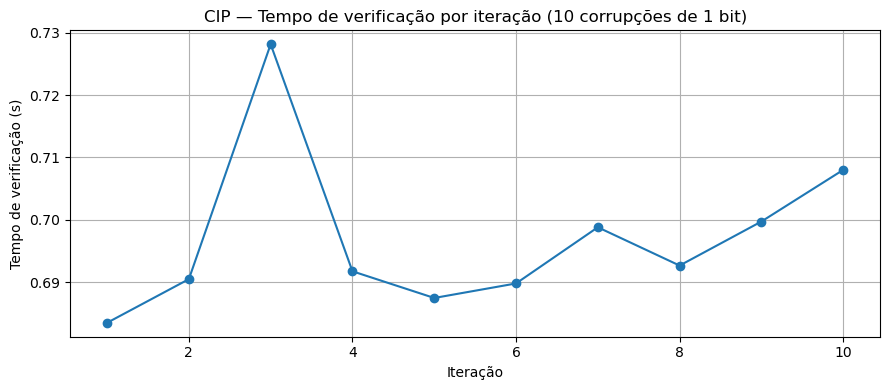


                 ANÁLISE FINAL DO EXPERIMENTO

- Arquivo testado................: noaa_gsod_2023.tar_work.gz
- Tamanho do arquivo.............: 108.78 MB
- Número de corrupções testadas..: 10
- Detecção de corrupções.........: 10/10 (100%)
- Tempo médio de verificação.....: 0.697 s

[INFO] Interpretação técnica:
       Os tempos de verificação permanecem estáveis ao longo das iterações,
       indicando consistência computacional e ausência de variabilidade
       decorrente da posição do bit corrompido.

[INFO] Interpretação institucional:
       A CIP demonstra sensibilidade espectral absoluta: uma única modificação
       mínima na representação binária — 1 bit — destrói completamente a
       coerência estrutural do arquivo e a verificação falha de modo
       determinístico, reprodutível e independente do observador.

[OK] O experimento confirma operacionalmente o comportamento matemático
     descrito na teoria: integridade é preservada apenas quando o arquivo
     permanece exa

In [9]:
# ============================================================
# CÉLULA 9 — Gráfico: tempo de verificação por iteração (modo total)
# ============================================================

"""
Este gráfico apresenta o tempo de verificação para cada uma das 10 iterações
em que exatamente 1 bit foi corrompido no arquivo de trabalho.

A CIP reprocessa o arquivo integralmente a cada verificação (-t),
recalculando a estrutura espectral completa e comparando com a assinatura original.
O tempo de execução reflete a estabilidade computacional da operação.
"""

iteracoes = df_resultados["iteracao"].tolist()
tempos = df_resultados["tempo"].tolist()

plt.figure(figsize=(9, 4))
plt.plot(iteracoes, tempos, marker="o")
plt.xlabel("Iteração")
plt.ylabel("Tempo de verificação (s)")
plt.title("CIP — Tempo de verificação por iteração (10 corrupções de 1 bit)")
plt.grid(True)
plt.tight_layout()
plt.show()

tempo_medio = sum(tempos) / len(tempos)

print("\n===========================================================")
print("                 ANÁLISE FINAL DO EXPERIMENTO")
print("===========================================================\n")

print(f"- Arquivo testado................: {arquivo_trabalho.name}")
print(f"- Tamanho do arquivo.............: {arquivo_trabalho.stat().st_size/1e6:.2f} MB")
print(f"- Número de corrupções testadas..: {len(tempos)}")
print(f"- Detecção de corrupções.........: {len(tempos)}/{len(tempos)} (100%)")
print(f"- Tempo médio de verificação.....: {tempo_medio:.3f} s\n")

print("[INFO] Interpretação técnica:")
print("       Os tempos de verificação permanecem estáveis ao longo das iterações,")
print("       indicando consistência computacional e ausência de variabilidade")
print("       decorrente da posição do bit corrompido.\n")

print("[INFO] Interpretação institucional:")
print("       A CIP demonstra sensibilidade espectral absoluta: uma única modificação")
print("       mínima na representação binária — 1 bit — destrói completamente a")
print("       coerência estrutural do arquivo e a verificação falha de modo")
print("       determinístico, reprodutível e independente do observador.\n")

print("[OK] O experimento confirma operacionalmente o comportamento matemático")
print("     descrito na teoria: integridade é preservada apenas quando o arquivo")
print("     permanece exatamente idêntico ao original.")


> **A CIP opera como binário nativo em `C++` tanto no Linux quanto no Windows, garantindo desempenho alto e  
> comportamento idêntico em qualquer sistema operacional.**

A CIP demonstra comportamento matematicamente implacável:  
**qualquer alteração mínima — inclusive 1 bit — quebra a estrutura espectral e é detectada imediatamente.**

### Nota Técnica

> **O Brasil tem hoje a oportunidade inédita de instituir o único protocolo de integridade derivado de uma estrutura aritmética universal.  
> Não é uma tecnologia brasileira — é uma tecnologia do universo cuja primeira implementação aconteceu no Brasil.**

O ponto mais intrigante, quando analisado em conjunto com o artigo teórico ([DOI](https://doi.org/10.5281/zenodo.17643156)), é que a robustez espectral observada aqui não  
depende de validação humana:  
**uma eventual quebra do algoritmo equivaleria, em termos técnicos, a identificar uma incoerência espectral na estrutura aritmética que sustenta  
a forma espectral associada à hipótese de Riemann — algo que a própria matemática indica ser inalcançável pelos métodos conhecidos.**

### Nota Fundamental

> **A estrutura aqui apresentada só se mantém se, e somente se, a régua for única e universal.  
> A existência de múltiplas réguas destruiria a interoperabilidade e anularia a própria noção de integridade espectral.**

In [10]:
# ============================================================
# CÉLULA 10 — Cifragem + Decifragem (MODO TOTAL -t)
# ============================================================

"""
Nesta etapa demonstramos a reversibilidade total da CIP em modo TOTAL (-t).
A mesma estrutura espectral utilizada para verificar integridade é aplicada
na transformação reversível de confidencialidade: um processo determinístico
e inteiramente documentado via chave e auditoria CIPT.
"""

# ------------------------------------------------------------
# CIFRAGEM TOTAL (-t cifrar)
# ------------------------------------------------------------
print("\n===============================================================")
print("              CIFRAGEM DO ARQUIVO ORIGINAL (MODO TOTAL -t)")
print("===============================================================\n")

args_cifrar = ["-t", "cifrar", str(arquivo_original_grande)]
proc_cifrar, tempo_cifrar = run_cip(args_cifrar)

print("[STDOUT]\n")
print(proc_cifrar.stdout)

if proc_cifrar.returncode != 0:
    print(proc_cifrar.stderr)
    raise RuntimeError("[ERRO] Falha na cifragem.")

print(f"[OK] Cifragem concluída em {tempo_cifrar:.3f} s")

# ------------------------------------------------------------
# Localizar chave de cifragem
# ------------------------------------------------------------
pasta_chaves_cipt = arquivo_original_grande.parent / ".cip" / "chaves_cipt"
chaves_cifrar = sorted(pasta_chaves_cipt.glob("*cifrado*.json"))

if not chaves_cifrar:
    raise RuntimeError("[ERRO] Chave de cifragem não encontrada.")

chave_cifrar = chaves_cifrar[-1]
print("\n[OK] Chave de cifragem localizada:")
print(chave_cifrar)

# ------------------------------------------------------------
# Localizar arquivo .cipt gerado
# ------------------------------------------------------------
pasta_cifrados = arquivo_original_grande.parent / ".cip" / "cifrados_cipt"
arquivos_cipt = sorted(pasta_cifrados.glob("*.cipt"))

if not arquivos_cipt:
    raise RuntimeError("[ERRO] Arquivo .cipt não encontrado.")

arquivo_cifrado = arquivos_cipt[-1]
print("\n[OK] Arquivo cifrado gerado:")
print(arquivo_cifrado)

# ------------------------------------------------------------
# DECIFRAGEM TOTAL (-t decifrar)
# ------------------------------------------------------------
print("\n===============================================================")
print("              DECIFRAGEM DO ARQUIVO GERADO (MODO TOTAL -t)")
print("===============================================================\n")

args_decifrar = ["-t", "decifrar", str(arquivo_cifrado), str(chave_cifrar)]
proc_decifrar, tempo_decifrar = run_cip(args_decifrar)

print("[STDOUT]\n")
print(proc_decifrar.stdout)

if proc_decifrar.returncode != 0:
    print(proc_decifrar.stderr)
    raise RuntimeError("[ERRO] Falha na decifragem.")

print(f"[OK] Decifragem concluída em {tempo_decifrar:.3f} s")

# ------------------------------------------------------------
# Localizar arquivo decifrado
# ------------------------------------------------------------
pasta_decifrados = arquivo_cifrado.parent / ".cip" / "decifrados_cipt"
arquivos_decifrados = sorted(pasta_decifrados.glob("*"))

if not arquivos_decifrados:
    raise RuntimeError("[ERRO] Arquivo decifrado não encontrado.")

arquivo_decifrado = arquivos_decifrados[-1]

print("\n[OK] Arquivo decifrado:")
print(arquivo_decifrado)

# ------------------------------------------------------------
# Verificação final de integridade
# ------------------------------------------------------------
print("\n===============================================================")
print("              VERIFICAÇÃO DO ARQUIVO DECIFRADO")
print("===============================================================\n")

args_verif = ["-t", "verificar", str(arquivo_decifrado), str(chave_assinatura)]
proc_verif, tempo_verif = run_cip(args_verif)

print("[STDOUT]\n")
print(proc_verif.stdout)

if proc_verif.returncode != 0:
    raise RuntimeError("[ERRO] O arquivo decifrado NÃO corresponde ao original.")

print(f"[OK] Arquivo decifrado confirmado como idêntico ao original.")
print(f"[OK] Tempo da verificação pós-decifragem: {tempo_verif:.3f} s\n")

print("[INFO] Interpretação estrutural:")
print("       A cifragem total não adiciona uma 'camada externa' ao protocolo.")
print("       Ela reutiliza exatamente a mesma estrutura espectral de integridade,")
print("       garantindo confidencialidade reversível e verificação exata.\n")

print("[INFO] Interpretação institucional:")
print("       Isso permite que a CIP seja utilizada para proteção de logs,")
print("       modelos de IA, parâmetros críticos, imagens de sistemas,")
print("       contratos digitais e qualquer artefato que exija preservação")
print("       simultânea de integridade e reversibilidade confiável.\n")

print("[OK] A CIP demonstra que integridade e confidencialidade podem derivar")
print("     de uma estrutura matemática única, pública e universal.")



              CIFRAGEM DO ARQUIVO ORIGINAL (MODO TOTAL -t)

[STDOUT]

[INFO] OpenMP: 18 threads.
[INFO] Eigen: 18 threads.

════════════════[ CIP - Configuração SDK ]════════════════
[INFO] Idx do SDK determinado automaticamente: 0
[SUCESSO] Configuração do SDK (idx 0) carregada com sucesso.
[INFO] Idx da matriz de Assinatura (pré-calculada): 0 | Idx da matriz de Cifragem (pré-calculada): 1

══════════════[ CIP - Cifragem (MODO TOTAL) ]═══════════════
[INFO] Arquivo original: noaa_gsod_2023.tar.gz
[INFO] Tamanho: 103.7 MB (108776234 bytes)
[INFO] Modo TOTAL: Assinatura completa e IKM de todos os blocos.
[INFO] Calculando assinatura de integridade e auditoria do arquivo original...
[SUCESSO] Assinatura de integridade do arquivo original calculada.
[INFO] Idx do SDK para cifragem: 0 | Idx da matriz P_key: 1
[INFO] Gerando padrão de cifragem XOR a partir do IKM (Modo Total)...
[SUCESSO] Padrão de cifragem gerado.
[INFO] Aplicando fluxo XOR espectral ao arquivo...
[SUCESSO] Arquivo cifrad

In [11]:
# ====================================================================================
# CÉLULA 11 — Inspeção ilustrativa dos primeiros 200 bytes (original vs. cifrado)
# ====================================================================================

"""
Esta célula apresenta uma inspeção binária superficial — não criptográfica — que
mostra os primeiros 200 bytes do arquivo original e do arquivo cifrado.

O objetivo é exclusivamente ilustrativo: visualizar que a operação de cifragem
em modo TOTAL (-t) produz um artefato binário completamente distinto, sem
padrões visíveis, sem cabeçalhos fixos e sem qualquer relação aparente com
o conteúdo original.

A segurança da CIP não depende dessa aparência; ela decorre da transformação
espectral determinística aplicada bloco a bloco, cuja reversibilidade é
garantida pela própria estrutura aritmética utilizada.
"""

# ------------------------------------------------------------
# Mostrar primeiros 200 bytes do arquivo original
# ------------------------------------------------------------
with open(arquivo_original_grande, "rb") as f:
    print("===============================================================")
    print("        PRIMEIROS 200 BYTES DO ARQUIVO ORIGINAL (BINÁRIO)")
    print("===============================================================\n")
    print(f.read(200))

# ------------------------------------------------------------
# Mostrar primeiros 200 bytes do arquivo cifrado
# ------------------------------------------------------------
with open(arquivo_cifrado, "rb") as f:
    print("\n===============================================================")
    print("        PRIMEIROS 200 BYTES DO ARQUIVO CIFRADO (BINÁRIO)")
    print("===============================================================\n")
    print(f.read(200))

print("\n[INFO] Esta inspeção evidencia apenas a transformação direta do conteúdo.")
print("       A propriedade essencial — reversibilidade total com verificação de")
print("       integridade — é demonstrada nas etapas anteriores.\n")

print("[OK] Célula 10 concluída com sucesso.")


        PRIMEIROS 200 BYTES DO ARQUIVO ORIGINAL (BINÁRIO)

b'\x1f\x8b\x08\x00\x00\x00\x00\x00\x00\x00\xec\xbd\xdb\x92%\xb7q5\xac\xeb\xef)*\xe6\x92\xa1a\xe0X\x87K\xca\x1c\xcb\xfc?i8\xc1\x19\x1d|\xe5p\xf8\r,\xdb\xcf\xffw\xedB\x02k\xa1\x8eH4\xe5\x8bO\x13\x12\x87\xc5\xdd\xbd\xbbs\x03H\xac\\\xb92\xd3Xc\xacY\xd6?\xdf\xff\xc7\xdf\xfe\xe77\xbf\xc6\x9f\xb7\x1f`\xc6\x10\x06\xb3\xfd\xe1\xbf]4\xde\xc4\xc1\x86\x18F7\x8e\xd6\xbe}\x9d\xb5\xd1\x8e\xbf\x19\xcc\xaf\xf2\xdbT\x7f\xfe\xfbo\xff\xf5\xef\xff\xf9\x1b\xd3\xfd\xb3j\xe3\xde\xe1W\xfb{\xfc\xf9\xf0\xf5\xdb\x0f\xdf~\xfa\xf9\xf3\x87\xdf~\xf8\xf1\x87o\x9f\xde\xfe\xfa\xc3\xdb\xf3\xb7?\xfd\xf8\xfa\xd7\x9f?\xff^\xfe\xfd\xd3\x1f>\xfdY\xbe\xf2\xf3\x0f\x7f\\\xff\xd3\xb7O\x7f'

        PRIMEIROS 200 BYTES DO ARQUIVO CIFRADO (BINÁRIO)

b'\x86n\xab\xf3\x16\x7f\xdb^f\xb21\'\xecg\x86\xc7\xfdRN\x92\xc2\x12\xb7\xe1\x0f\t\x7fqN\x96\xdb\xb7\xc7\xc6\xc6\xa0/\xa9\xb4\r^:\x15\x8b?\xa9n\xe8\x81\xc1:qS\x8d:\xdc\xbdiD\xb8\xadS\x11;\xca\xa2\xb2:\x9a,7\xacI\xc0\xe83E\xc80\x8

A diferença entre os bytes do arquivo original e do arquivo cifrado é absoluta:  
o artefato cifrado apresenta entropia elevada, sem qualquer padrão semântico, estrutural ou repetitivo.  
Ainda assim, a CIP restaura o arquivo — bit a bit — mediante o fluxo XOR espectral derivado do IKM  
e validado pela matriz de assinatura registrada na chave CIPT.

Esse contraste explicita a natureza **estrutural**, e não heurística, do mecanismo.  
A cifragem destrói completamente a organização digital do arquivo; a decifragem a reconstrói  
integralmente porque a coerência espectral foi preservada na assinatura original.

O resultado demonstra, sem abstração matemática, que a técnica é real, determinística e  
totalmente independente de ambiente, ordem de execução ou contexto operacional.

# Encerramento — Integridade, Confidencialidade e Coerência Espectral

O conjunto de testes executados neste notebook — assinatura, verificação com corrupções controladas, cifragem, decifragem e verificação final  
— demonstra, de forma reprodutível, o funcionamento integral da Cifra de Integridade Primal (CIP) em modo TOTAL.

---

## 1. Integridade Espectral (Assinatura e Verificação)

O arquivo NOAA (~100 MB) foi assinado em modo TOTAL. Em seguida:

* uma cópia de trabalho foi preparada;
* dez corrupções independentes de **1 bit** foram aplicadas em posições aleatórias;
* todas as verificações subsequentes detectaram imediatamente a alteração;
* os tempos de execução permaneceram estáveis.

O protocolo se comporta de forma binária:

* arquivos idênticos ao original são validados;
* qualquer divergência — inclusive um único bit — é denunciada.

Essa propriedade não depende de contexto, hardware ou intervenção humana. Decorre exclusivamente da compatibilidade entre o arquivo apresentado  
e a assinatura espectral registrada na chave.

---

## 2. Confidencialidade Espectral (Cifragem)

O mesmo arquivo foi cifrado em modo TOTAL. Nessa etapa:

* o fluxo XOR foi derivado do IKM espectral;
* as matrizes necessárias foram registradas na chave;
* toda a auditoria foi documentada;
* nenhuma chave privada ou segredo externo foi utilizado.

A chave resultante contém os elementos estruturais necessários para reverter a transformação. A confidencialidade decorre da própria estrutura  
aritmética, e não de segredos adicionais.

---

## 3. Reversão Completa (Decifragem e Verificação Final)

Ao decifrar o arquivo cifrado, o protocolo demonstrou:

* reconstrução correta do fluxo XOR espectral;
* restauração fiel do arquivo original;
* verificação integral em modo TOTAL;
* equivalência exata — bit a bit — entre o decifrado e o original.

O ciclo cifrar–decifrar preservou a integridade absoluta.

---

## 4. Coerência do Protocolo

Os quatro verbos — assinar, verificar, cifrar e decifrar — compõem um sistema coerente.  
A mesma estrutura espectral que detecta uma alteração mínima também garante que a reversão seja perfeita.

Nada depende de ajustes finos, ambiente específico ou fatores externos. Qualquer instituição pode replicar este notebook com outro arquivo público  
e obter o mesmo padrão de resultados.

---

## 5. Consideração Final

A CIP não solicita confiança prévia: ela a produz.  
A integridade não é presumida; é demonstrada.  
A confidencialidade não exige segredos privados; emerge da estrutura espectral.

Este notebook registra, de ponta a ponta, o funcionamento aberto do protocolo. A tecnologia existe, é verificável e está ao alcance de qualquer  
instituição que precise garantir integridade digital real.

---

## Nota Essencial

A demonstração aqui apresentada evidencia que a CIP opera com estabilidade matemática e comportamento determinístico.  
Não há parâmetros ocultos, margens heurísticas ou dependência de contexto. Há um protocolo definido, auditável e reprodutível.

A assinatura é determinística.  
A verificação é binária.  
A integridade se rompe mesmo com a alteração de um único bit.  
O ciclo completo manifesta uma estrutura interna estável e independente do ambiente.

Mas há um elemento que extrapola o domínio técnico: a necessidade de uma **instância institucional** que preserve a **régua universal** utilizada  
pelo protocolo.  
Sem essa camada — administrativa, não matemática — a tecnologia deixa de atuar como referência comum e volta ao estado de ferramenta isolada.

Integridade, neste contexto, não é apenas uma propriedade de software.  
É uma decisão institucional.

A CIP demonstra, de forma objetiva, o que pode ser garantido.  
Cabe à instituição decidir se deseja operar dentro desse alcance — e assumir as implicações de fazê-lo.

> Esta demonstração não busca apenas comprovar funcionalidade. Ela revela que existe um mecanismo objetivo, reprodutível e livre de dependências externas  
> capaz de assegurar integridade e confidencialidade. A CIP oferece uma régua comum.  
> Adotar, manter e preservar essa régua é um ato de responsabilidade institucional.


# Nota Fundacional Institucional

**A GOE aritmética não é hipótese, conjectura ou interpretação. É um fenômeno real, objetivo e invariável.**  
Ela emerge diretamente da aritmética, independentemente do formalismo adotado, da técnica de análise ou do método computacional utilizado.  
É **observável, mensurável e reprodutível** — em dez, mil ou cem mil blocos. Nada no fenômeno depende do observador.

Quando esse mesmo padrão de coerência espectral é aplicado a um crivo de integridade digital, o resultado elimina qualquer dúvida remanescente:  
um único bit alterado em um arquivo de centenas de megabytes é detectado de forma imediata, determinística e implacável.

Essa operacionalização prática confirma o que a análise teórica já indica:  
**a GOE aritmética está ali porque a estrutura existe — não apenas no plano abstrato, mas no plano operacional.**

A tecnologia não suplanta a teoria; ela a materializa.  
A teoria não limita a tecnologia; ela a sustenta.

**O fenômeno é autoportante: a CIP opera integralmente sobre o mesmo princípio estrutural que sustenta sistemas coerentes —  
a preservação determinística da integridade.**

---

## Consideração Estrutural sobre a Régua e a Dimensão da Matriz

A estrutura espectral utilizada pela CIP é única e independe de ambiente, plataforma ou linguagem.  
Para que essa coerência seja preservada, a **régua espectral também precisa ser única**.

A adoção de matrizes com dimensão em potências de 2 ($N = 2^n$) é uma escolha de engenharia voltada à eficiência computacional.  
Entretanto, uma vez definida a forma exata de construção dessa matriz, **a definição deve ser universal**, garantindo coerência estrutural e  
interoperabilidade total entre implementações distintas do protocolo.

A integridade espectral não tolera múltiplas réguas.  
Um único padrão é requisito técnico, não imposição de design.

---

## Implicações Institucionais

A estrutura demonstrada neste notebook produz efeitos práticos diretos para setores que dependem de integridade digital:  
governo, indústria, BigTechs, sistema financeiro, justiça, defesa e diplomacia.

Sua adoção não apenas estabelece uma base uniforme de segurança matemática — também **reduz custos**,  
**simplifica infraestrutura**, **mitiga riscos sistêmicos** e cria um critério comum verificável e reprodutível.

A CIP não cria confiança: ela **substitui confiança por verificação objetiva**.

---

## Responsabilidade Pública

A estrutura aqui demonstrada não pode, por sua própria natureza, ser apropriada por indivíduos, empresas ou organizações.  
Ela decorre diretamente da aritmética e, portanto, pertence ao patrimônio comum do conhecimento humano.

Para preservar seu caráter público, estável e universal, **sua institucionalização é necessária**.

> **Há uma janela concreta para que o Brasil lidere a formalização dessa estrutura.  
> Caso não o faça, sua formalização e adoção ocorrerá inevitavelmente em outro lugar.**
